In [1]:
import os
import sys
seed=42
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(seed)
import scipy
import torch
from pykrige.ok import OrdinaryKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk import UniversalKriging
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline


In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'

filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)
data.replace(0,np.nan,inplace=True)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan
df = np.log(df)
df = df.drop(['Pusa_IMD'], axis=1)

In [6]:
def process_row(idx, row):
    window_size = 3
    i = np.where(np.array(df.index) == idx)[0][0]
    df_slice = pd.concat([df[i-window_size:i],df[i+1:i+window_size+1]])
    x_win = locs.loc[df.columns]['Longitude'].values
    x_win = np.tile(x_win,df_slice.shape[0])
    y_win = locs.loc[df.columns]['Latitude'].values
    y_win = np.tile(y_win,df_slice.shape[0])    
    z_win = np.concatenate([np.arange(i-window_size,i),np.arange(i+1,i+window_size+1)])*0.01
    z_win = np.repeat(z_win,len(df.columns))
    vals_win = df_slice.values.flatten()
    x_win = x_win[~np.isnan(vals_win)]
    y_win = y_win[~np.isnan(vals_win)]
    z_win = z_win[~np.isnan(vals_win)]
    vals_win = vals_win[~np.isnan(vals_win)]
    
    x = locs.loc[df.columns]['Longitude'].values
    y = locs.loc[df.columns]['Latitude'].values
    z = np.ones_like(x)*i*0.01
    vals = row.values
    cols = np.array(df.columns)[~np.isnan(vals)]
    x = x[~np.isnan(vals)]
    y = y[~np.isnan(vals)]
    z = z[~np.isnan(vals)]
    vals = vals[~np.isnan(vals)]
    
    x_train = np.concatenate([x,x_win])
    y_train = np.concatenate([y,y_win])
    z_train = np.concatenate([z,z_win])
    vals_train = np.concatenate([vals,vals_win])


    OK3D = OrdinaryKriging3D(
        x_train,
        y_train,
        z_train,
        vals_train,
        variogram_model="linear",
        verbose=False,
        enable_plotting=False,
    )
    
    gridx = np.arange(77.01, 77.40, 0.01)
    gridy = np.arange(28.39, 28.78, 0.01)
    gridz = i*0.01
    vals_grid, ss_grid = OK3D.execute("grid", gridx, gridy, gridz)
    vals_grid = np.exp(vals_grid)
    return(vals_grid)

In [7]:
result_list = Parallel(n_jobs=4)(delayed(process_row)(idx,row) for idx,row in df[4:100].iterrows())
grid_arr = np.concatenate(result_list)

In [27]:
grid_arr.shape[0]

96

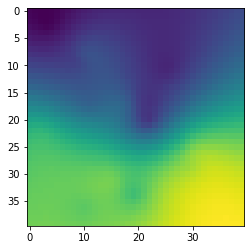

In [15]:
plt.imshow(grid_arr[45])

In [17]:
df.index

DatetimeIndex(['2018-05-01 00:00:00+05:30', '2018-05-01 01:00:00+05:30',
               '2018-05-01 02:00:00+05:30', '2018-05-01 03:00:00+05:30',
               '2018-05-01 04:00:00+05:30', '2018-05-01 05:00:00+05:30',
               '2018-05-01 06:00:00+05:30', '2018-05-01 07:00:00+05:30',
               '2018-05-01 08:00:00+05:30', '2018-05-01 09:00:00+05:30',
               ...
               '2020-10-31 14:00:00+05:30', '2020-10-31 15:00:00+05:30',
               '2020-10-31 16:00:00+05:30', '2020-10-31 17:00:00+05:30',
               '2020-10-31 18:00:00+05:30', '2020-10-31 19:00:00+05:30',
               '2020-10-31 20:00:00+05:30', '2020-10-31 21:00:00+05:30',
               '2020-10-31 22:00:00+05:30', '2020-10-31 23:00:00+05:30'],
              dtype='datetime64[ns, pytz.FixedOffset(330)]', name='timestamp_round', length=21960, freq=None)

In [20]:
df_heatmaps = pd.DataFrame(grid_arr.reshape(grid_arr.shape[0],1600), index=df.index)

In [28]:
df_heatmaps

,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
timestamp_round,,,,,,,,,,,,,,,,,,,,,
2018-05-01 04:00:00+05:30,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,...,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875,46.282875
2018-05-01 05:00:00+05:30,45.556103,45.556103,45.556103,45.556103,45.556103,45.556103,45.556103,45.556103,45.556103,45.556103,...,45.556103,45.556104,45.556104,45.556104,45.556104,45.556104,45.556104,45.556104,45.556104,45.556104
2018-05-01 06:00:00+05:30,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,...,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919,46.177919
2018-05-01 07:00:00+05:30,46.184133,46.158475,46.128288,46.091000,46.044925,45.991626,45.935333,45.880414,45.830259,45.787257,...,47.769131,47.798485,47.823646,47.844612,47.861552,47.874759,47.884598,47.891470,47.895774,47.897892
2018-05-01 08:00:00+05:30,48.248577,48.248576,48.248575,48.248573,48.248572,48.248570,48.248568,48.248567,48.248565,48.248564,...,48.248656,48.248656,48.248656,48.248655,48.248655,48.248654,48.248654,48.248653,48.248653,48.248652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-04 23:00:00+05:30,61.376660,61.114505,60.848091,60.568065,60.268776,59.960408,59.665314,59.404562,59.192844,59.039152,...,86.947202,86.668249,86.386383,86.108149,85.837929,85.578351,85.330729,85.095468,84.872381,84.660937
2018-05-05 00:00:00+05:30,62.666702,62.159614,61.583552,60.889506,60.046477,59.090322,58.106410,57.174049,56.346410,55.654397,...,89.959647,89.573451,89.144442,88.695601,88.242973,87.797010,87.364017,86.947416,86.548743,86.168362
2018-05-05 01:00:00+05:30,61.984573,61.346130,60.576600,59.590122,58.333937,56.873015,55.355913,53.916602,52.642168,51.581881,...,88.738033,88.164787,87.562801,86.960364,86.375480,85.818288,85.293445,84.802103,84.343356,83.915230
